Datasets source : https://www.kaggle.com/christophercorrea/dc-residential-properties

Dataset : DC_Properties.csv

Key-variabls:
- <b>PRICE</b>: Price of most recent sale (Numeric/Target variable)
- <b>X</b>: longitude (Numeric/non-linear relationship)
- <b>Y</b>: latitude (Numeric/non-linear relationship)
- <b>LANDAREA</b>: Land area of property in square feet (Numeric)
- <b>GBA</b>: Gross building area in square feet (Numeric)
- <b>LIVING_GBA</b>: Gross building area in square feet
- <b>BATHRM</b>: Number of bathrooms (Count)
- <b>ROOMS</b>: Number of Rooms (Count)
- <b>KITCHENS</b>: Number of kitchens (Count)
- <b>BEDRM</b>: Number of Bedrooms (Count)
- <b>CNDTN</b>: Condition (Categorical)

Relevant-variables:
- <b>STYLE</b>: Style




Other-variables:

- <b>LATITUDE</b>: Latitude
- <b>LONGITUDE</b>: Longitude
- <b>HF_BATHRMNumber</b>: of Half Bathrooms (no bathtub or shower)
- <b>HEAT</b>: Heating
- <b>AC</b>: Cooling
- <b>NUM_UNITS</b>:Number of Units
- <b>AYB</b>: The earliest time the main portion of the building was built
- <b>YR_RMDL</b>: Year structure was remodeled
- <b>EYB</b>: The year an improvement was built more recent than actual year built
- <b>STORIES</b>: Number of stories in primary dwelling
- <b>SALEDATE</b>: Date of most recent sale
- <b>QUALIFIED</b>: Qualified
- <b>SALE_NUM</b>: Sale Number
- <b>BLDG_NUM</b>: Building Number on Property
- <b>STRUCT</b>: Structure
- <b>GRADE</b>: Grade
- <b>EXTWALL</b>: Extrerior wall
- <b>ROOF</b>: Roof type
- <b>INTWALL</b>: Interior wall
- <b>FIREPLACES</b>: Number of fireplaces
- <b>USECODE</b>: Property use code
- <b>GIS_LAST_MOD_DTTM</b>: Last Modified Date
- <b>SOURCE</b>: Raw Data Source
- <b>CMPLX_NUM</b>: Complex number
- <b>FULLADDRESS</b>: Full Street Address
- <b>CITY</b>: City
- <b>STATE</b>: State
- <b>ZIPCODE</b>: Zip Code
- <b>NATIONALGRID</b>: Address location national grid coordinate spatial address
- <b>ASSESSMENT_NBHD</b>: Neighborhood ID
- <b>ASSESSMENT_SUBNBHD</b>: Subneighborhood ID
- <b>CENSUS_TRACT</b>: Census tract
- <b>CENSUS_BLOCK</b>: Census block
- <b>WARD</b>: Ward (District is divided into eight wards, each with approximately 75,000 residents)
- <b>SQUARE</b>: Square (from SSL)
- <b>QUADRANT</b>: City quadrant (NE,SE,SW,NW)

## Decision log

> Decisions about the dataset have to be made before analysis due to the imperfect nature of the data.

> It might be 

The dataset has a lot of missing values. This is due to the dataset being merged from two or more other datasets, among which, one was for residential sales and another from condominium sales. Some variables are not common among the two, so we have to either drop them, fill in the missing values or merge similar values into one. 

- We decided to drop the variable 'rooms' which is the total number of rooms and instead use the seperate room types, since they have a higher correlation with the price together and offer more interpriteability. 

- We saw that the number of kitchens in a building had an inverse relationship with the price when it was included with the other room types and only had a weak correlation with the price when used alone. When used with a regularized model like lasso, it was also the first variable that had a 0 coefficient, meaning it was likely introducing more noise than information. The number of kitchens is also only included in condominium data, so it might be dropped to avoid having to impute the data and since it's relationship does not appear to be important. <b> a decision has yet to be made whether to include this variable or not </b> 

- NUM_UNITS is a variable that's only included in residential data and has very little information, since a large majority is just the value 1 

- The decision was made to drop all sales marked as 'unqualified'. This is because a sale is considered unqualified if, for example, it is passed down to relatives, sold among multiple other properties or not at full market value. This would most likely give unrealistic expectations about the the value or expected sales price of properties.

- Variables that represent a year (year built, year remodeled, etc...) are recalculated as either 2018-year or [year sold]-[year of interest], so instead they can be thought of as 'age' or 'years since', since that relationship is easier to interprit as coefficients. We could see a drop in price in older houses which could produce a relationship like x-drop in price per year.  

- Year remodeled was turned into year built for missing values

- The following variables were removed on the basis that they introduced either no new information or that the information they introduced was redundant: 
    - ZIPCODE
    - CENSUS_BLOCK
    - CENSUS_TRACT
    - SQUARE
    - BLDG_NUM
    - FULLADDRESS
    - CITY
    - X
    - Y
    - NATIONALGRID
    - CMPLX_NUM
    - STATE
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
df = pd.read_csv('../Data/DC_Properties.csv')
print(df.shape)
pd.set_option('display.max_columns', 500)

(158957, 49)


C:\Users\gudmu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Helper functions

In [2]:
# Return range of non-outleries based on outliers being outside Q1 - IQR*1.5 and Q3 + IQR*1.5
def outlier_range(tmp_df,coeff = 1.5,verbose=False):
    tmp_df = tmp_df.copy().dropna()
    Q1 = tmp_df.dropna().quantile(0.25)
    Q3 = tmp_df.dropna().quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - IQR*coeff
    upper = Q3 + IQR*coeff
    df_filt = tmp_df.copy()
    df_filt = df_filt[(df_filt>lower) & (df_filt<upper)]
    if verbose:
        print('persentage of data removed:',100*np.round(1-(len(df_filt)/len(tmp_df)),3))
    return (np.min(df_filt),np.max(df_filt))

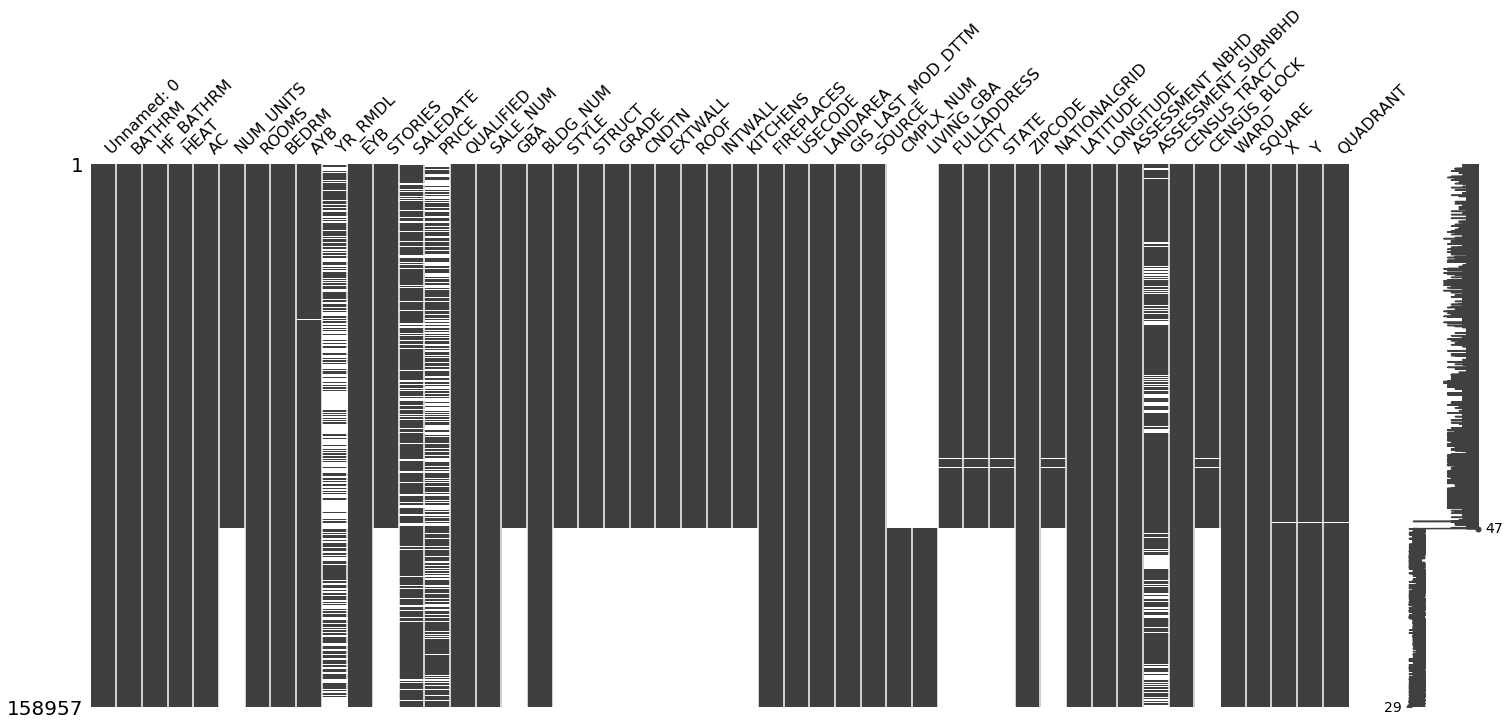

In [3]:
from missingno import matrix
matrix(df)

## Which room variables should we use?


In [4]:
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [5]:
print(len(X_train))

NameError: name 'X_train' is not defined

In [11]:
reg.coef_

NameError: name 'reg' is not defined

### Analyze difference in distributions between residential and condominium properties

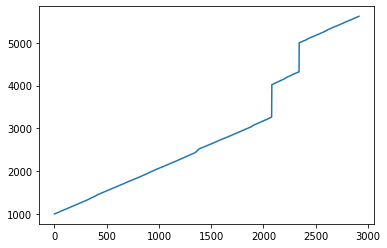

In [12]:
plt.plot(sorted(df.CMPLX_NUM.unique()))

### Date variables

In [13]:
date_vars = ['SALEDATE','GIS_LAST_MOD_DTTM']
for col in date_vars:
    df.loc[:,col] = pd.to_datetime(df.loc[:,col],format='%Y-%m-%d %H:%M:%S')
    
df.loc[:,date_vars].iloc[:3]

,SALEDATE,GIS_LAST_MOD_DTTM
0,2003-11-25,2018-07-22 18:01:43
1,2000-08-17,2018-07-22 18:01:43
2,2016-06-21,2018-07-22 18:01:43


### Other and useless variables

In [14]:
useless_vars = ['ZIPCODE','CENSUS_BLOCK','CENSUS_TRACT','SQUARE','BLDG_NUM']
other_vars = ['FULLADDRESS','CITY','X','Y','NATIONALGRID','CMPLX_NUM','STATE']

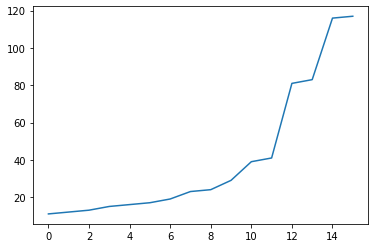

In [15]:
plt.plot(sorted(df.USECODE.unique()))

### Region variables

In [16]:
df.iloc[:2]

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,1972,3.0,2003-11-25,1095000.0,Q,1,2522.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,2.0,5,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1748 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23061 09289,38.914680,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,1972,3.0,2000-08-17,NaN,U,1,2567.0,1,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1746 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23067 09289,38.914683,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [17]:
loc_vars = ['']
region_vars = ['ASSESSMENT_NBHD','ASSESSMENT_SUBNBHD','WARD','QUADRANT']

### Categorical variables

In [18]:
cat_vars = ['HEAT','AC','QUALIFIED','STYLE','STRUCT',
            'GRADE','CNDTN','EXTWALL','ROOF','INTWALL','USECODE']

df.loc[:,cat_vars] = df.loc[:,cat_vars].astype(str)
df.loc[:,cat_vars].iloc[:3]

,HEAT,AC,QUALIFIED,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,USECODE
0,Warm Cool,Y,Q,3 Story,Row Inside,Very Good,Good,Common Brick,Metal- Sms,Hardwood,24
1,Warm Cool,Y,U,3 Story,Row Inside,Very Good,Good,Common Brick,Built Up,Hardwood,24
2,Hot Water Rad,Y,Q,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,24


In [19]:
# for col in cat_vars:
#     print(len(df.loc[:,col].unique()))
#     print(df.loc[:,col].unique())

### Integer variables (counted variables)


In [20]:
integer_vars = ['BATHRM','HF_BATHRM','NUM_UNITS','ROOMS',
                'BEDRM','SALE_NUM',
                'KITCHENS','FIREPLACES','STORIES']
df.loc[:,integer_vars] = df.loc[:,integer_vars].astype(float)
df.loc[:,integer_vars].iloc[:3]

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,SALE_NUM,KITCHENS,FIREPLACES,STORIES
0,4.0,0.0,2.0,8.0,4.0,1.0,2.0,5.0,3.0
1,3.0,1.0,2.0,11.0,5.0,1.0,2.0,4.0,3.0
2,3.0,1.0,2.0,9.0,5.0,3.0,2.0,4.0,3.0


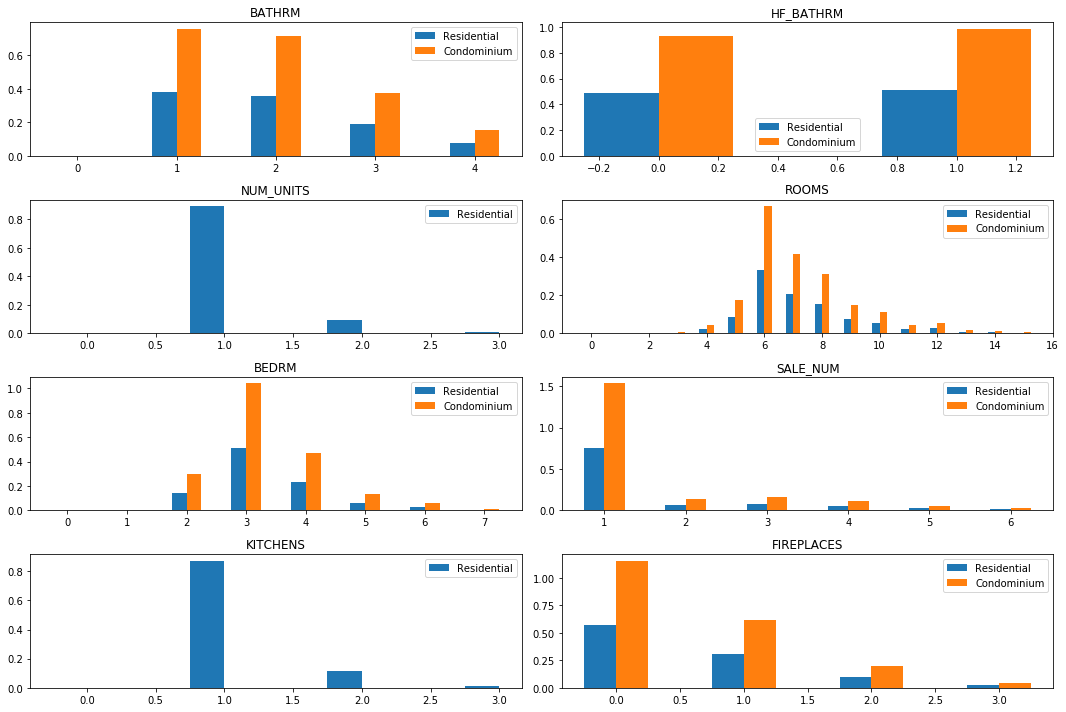

In [21]:
f,axes = plt.subplots(len(integer_vars)//2,2,figsize=(15,10))
axes = np.ravel(axes)
for ax,col in zip(axes,integer_vars):
#     print(col)
    tmp_data = df.loc[:,col]
    tmp_data = tmp_data[tmp_data < tmp_data.quantile(0.995)]
    tmp_data_cond = tmp_data.loc[df.loc[:,'SOURCE'] == 'Residential']
    tmp_data_res = tmp_data.loc[df.loc[:,'SOURCE'] == 'Condominium']
    cond_counts = tmp_data_cond.value_counts()
    res_counts = tmp_data_res.value_counts()
    width = 0.5
    if len(tmp_data_cond) > 0:
        ax.bar(cond_counts.index-width/4,cond_counts/len(tmp_data_cond),width=width/2)
    if len(tmp_data_res) > 0:
        ax.bar(cond_counts.index+width/4,cond_counts/len(tmp_data_res),width=width/2)
    
    ax.legend(['Residential','Condominium'])
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

### Float variables (continuous )


In [22]:
float_vars = ['LATITUDE','LONGITUDE','PRICE','GBA','LIVING_GBA','LANDAREA','AYB','YR_RMDL','EYB']
df.loc[:,float_vars] = df.loc[:,float_vars].astype(float)
df.loc[:,float_vars].iloc[:3]

,LATITUDE,LONGITUDE,PRICE,GBA,LIVING_GBA,LANDAREA,AYB,YR_RMDL,EYB
0,38.914680,-77.040832,1095000.0,2522.0,NaN,1680.0,1910.0,1988.0,1972.0
1,38.914683,-77.040764,NaN,2567.0,NaN,1680.0,1898.0,2007.0,1972.0
2,38.914684,-77.040678,2100000.0,2522.0,NaN,1680.0,1910.0,2009.0,1984.0


persentage of data removed: 0.0
persentage of data removed: 0.0
persentage of data removed: 4.0
persentage of data removed: 3.5999999999999996
persentage of data removed: 2.0


C:\Users\gudmu\Anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


persentage of data removed: 4.3999999999999995
persentage of data removed: 0.1
persentage of data removed: 0.1
persentage of data removed: 3.9


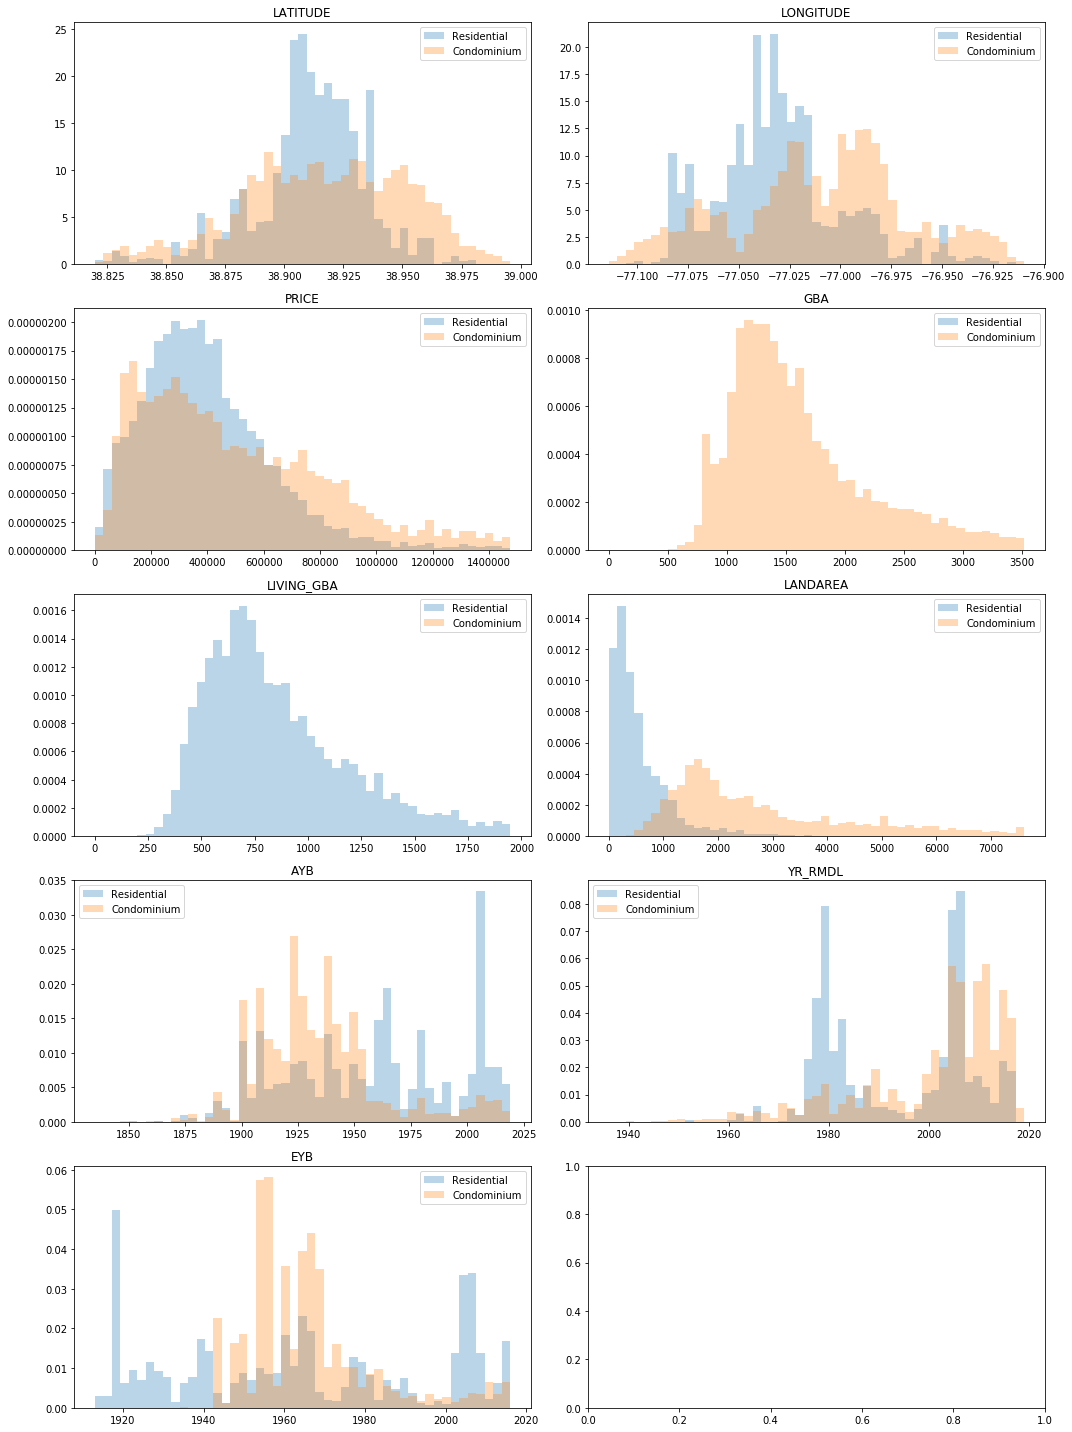

In [23]:
f,axes = plt.subplots(len(float_vars)//2+len(float_vars)%2,2,figsize=(15,len(float_vars)//2*5))
axes = np.ravel(axes)
for ax,col in zip(axes,float_vars):
    tmp_data = df.loc[:,col]
    lower,upper = outlier_range(tmp_data,2,True)
    
    tmp_data_cond = tmp_data.loc[df.loc[:,'SOURCE'] == 'Residential'].dropna()
    tmp_data_res = tmp_data.loc[df.loc[:,'SOURCE'] == 'Condominium'].dropna()
    
    bins = np.linspace(lower,upper,50)
    
    
    ax.hist(tmp_data_res,alpha=0.3,bins=bins,density=True)
    ax.hist(tmp_data_cond,alpha=0.3,bins=bins,density=True)
    ax.legend(['Residential','Condominium'])
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

In [24]:
sorted_vars = np.unique(float_vars + integer_vars + cat_vars + useless_vars + other_vars + date_vars)
useful_vars = np.unique(float_vars + integer_vars + cat_vars + date_vars)

In [25]:

tmp_data_res = df.loc[df.loc[:,'SOURCE'] == 'Residential']
tmp_data_cond = df.loc[df.loc[:,'SOURCE'] == 'Condominium']

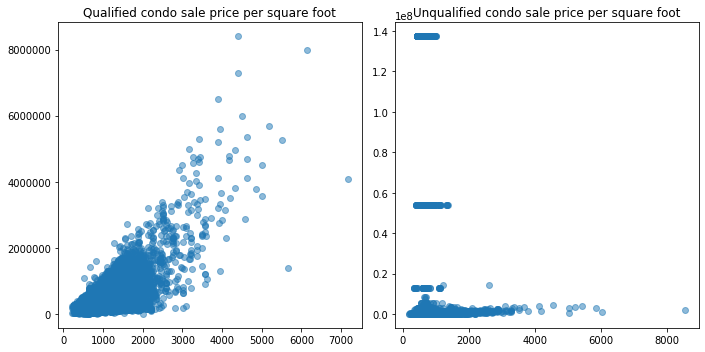

In [26]:
# plt.scatter(tmp_data_res['GBA'],tmp_data_res['PRICE'])
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(tmp_data_cond.loc[tmp_data_cond.QUALIFIED == 'Q','LIVING_GBA'],
              tmp_data_cond.loc[tmp_data_cond.QUALIFIED == 'Q','PRICE'],alpha=0.5)
ax[1].scatter(tmp_data_cond.loc[tmp_data_cond.QUALIFIED == 'U','LIVING_GBA'],
              tmp_data_cond.loc[tmp_data_cond.QUALIFIED == 'U','PRICE'],alpha=0.5)
ax[0].set_title('Qualified condo sale price per square foot')
ax[1].set_title('Unqualified condo sale price per square foot')
plt.tight_layout()
plt.show()

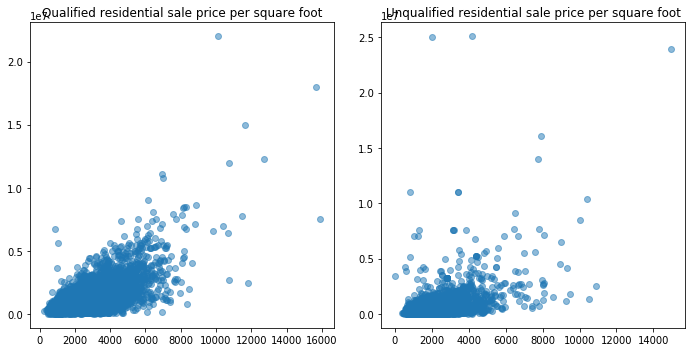

In [27]:
# plt.scatter(tmp_data_res['GBA'],tmp_data_res['PRICE'])
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(tmp_data_res.loc[tmp_data_res.QUALIFIED == 'Q','GBA'],
              tmp_data_res.loc[tmp_data_res.QUALIFIED == 'Q','PRICE'],alpha=0.5)
ax[1].scatter(tmp_data_res.loc[tmp_data_res.QUALIFIED == 'U','GBA'],
              tmp_data_res.loc[tmp_data_res.QUALIFIED == 'U','PRICE'],alpha=0.5)
ax[0].set_title('Qualified residential sale price per square foot')
ax[1].set_title('Unqualified residential sale price per square foot')

plt.tight_layout()
plt.show()

### Cleaning the dataframe based on lessons learned

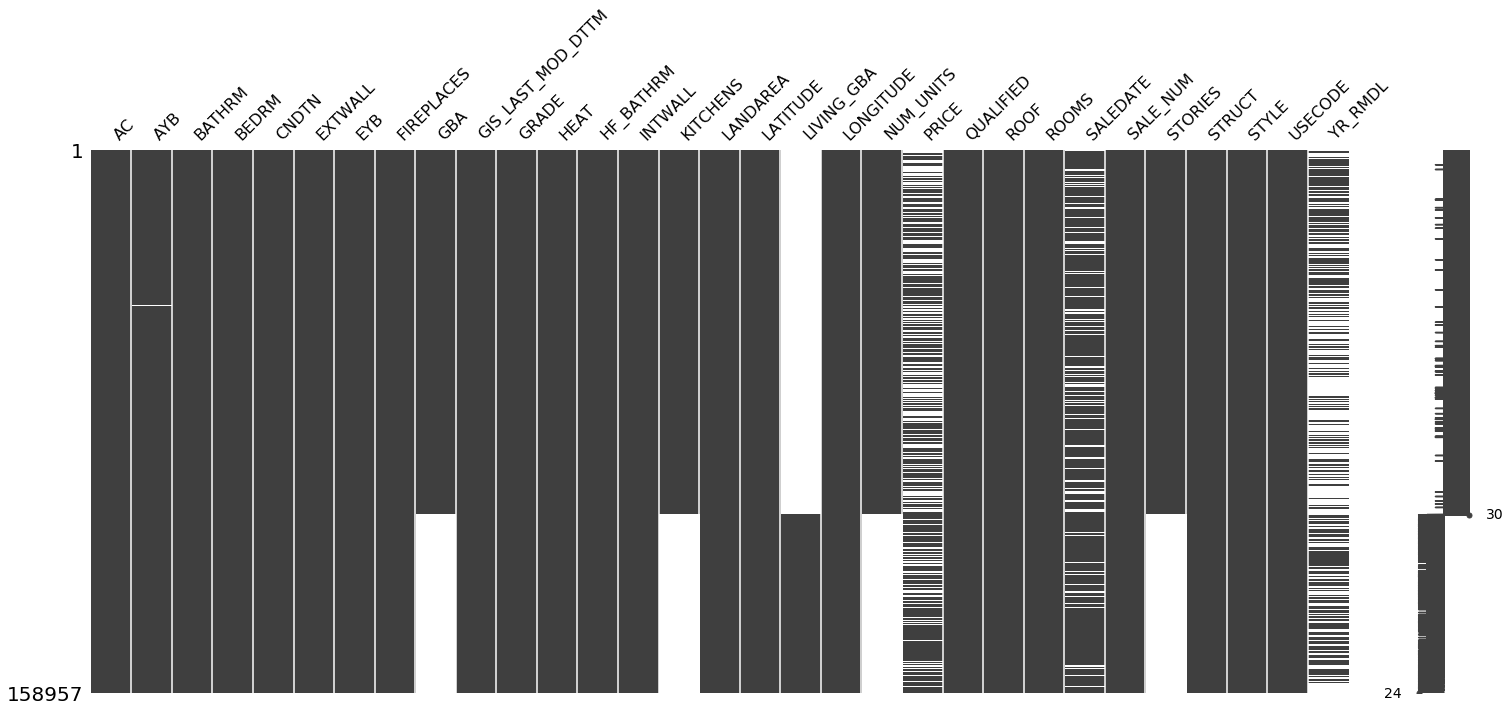

In [28]:
matrix(df.loc[:,useful_vars])


In [29]:
df.HEAT.value_counts()

Forced Air        53972
Hot Water Rad     47202
Warm Cool         33628
Ht Pump           21412
Wall Furnace       1120
Water Base Brd      402
Elec Base Brd       351
No Data             330
Electric Rad        144
Gravity Furnac      140
Air-Oil             117
Ind Unit             50
Evp Cool             50
Air Exchng           39
Name: HEAT, dtype: int64

In [30]:
# Variable that have dubious relationships with price, hard to impute for missing data, etc.
uncertain_variables = ['CNDTN', # Might be hard to impute. Could produce a new OHE variable for (missing value)
                       'GRADE', # Similar to condition and same reasoning
                       'EXTWALL', # Might be hard to impute. Could produce a new OHE variable for (missing value)
                       'INTWALL', # Similar to EXTWALL and same reasoning
                       'ROOF', # Similar to EXTWALL and INTWALL and same reasoning
                       'STRUCT', # Similar to EXTWALL, INTWALL & ROOF and same reasoning
                       'STYLE', # Similar to EXTWALL, INTWALL & ROOF and same reasoning
                       'NUM_UNITS', # Few unique values and only available for residential 
                       'QUALIFIED', # Good for filtering but not used for regression
                       'KITCHENS', # Dubious relationship and noisy data
                       'ROOMS', # similar to kitchens, and highly colinear with the higher resolution room data
                       'SALEDATE', # Used to modify other yearly data
                       'SALE_NUM', # Uncertain about the meaning of this variable
                       'STORIES', # Requires preprocessing. Take most common types and put rest into own category
                       'GIS_LAST_MOD_DTTM'] # Some trash variable (only two values with no meaning)
                       
                       

In [31]:
num_vars_keep = ['LATITUDE','LONGITUDE', # Location
                 'PRICE', # Output variable of interest
                 'BATHRM', # Number of bathrooms (Strong relationship)
                 'HF_BATHRM', # Number of half-bathrooms (likely relationship - maybe correlated with bathroom)
                 'BEDRM', # Number of bedrooms (String relationship)
                 'FIREPLACES', # Number of fireplaces (possible relationship, maybe indicator of old house)
                 'LANDAREA']

year_var_keep = ['EYB', # The year an improvement was built (likely relationship)
                 'YR_RMDL', # Year structure was remodeled]
                 'SALEDATE']
cat_vars_keep = ['HEAT', #Type of heating
                 'USECODE'] # Requires preprocessing. Take most common types and put rest into own category]

# To be combined into common variable later
GBA_vars = ['GBA','LIVING_GBA']

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
# Numerical data
df_num = df.loc[:,num_vars_keep].copy().dropna()

# Year-data
df_year = df.loc[:,year_var_keep]
# Turn missing remodel date into year built
# Turn 20 into NA and NA into year built
df_year.loc[df_year.loc[:,'YR_RMDL'] == 20,'YR_RMDL'] = None
df_year.loc[pd.isnull(df_year.loc[:,'YR_RMDL']),'YR_RMDL'] = df_year.loc[pd.isnull(df_year.loc[:,'YR_RMDL']),'EYB']
# Take year of sale
df_year.loc[:,'SALEYEAR'] = [x.year for x in df_year.SALEDATE]
# Replace missing data with the maximum of: the median saledate and the year remodeled 
df_year.loc[df_year.loc[:,'SALEYEAR'].isnull(),'SALEYEAR'] = df_year.loc[:,'SALEYEAR'].median()
df_year.loc[df_year.loc[:,'SALEYEAR'] < df_year.loc[:,'YR_RMDL'],'SALEYEAR'] = df_year.loc[:,'YR_RMDL']
# Create new variables, (time since year built at sale) and (time since remodelling at sale)
df_year.loc[:,'TSEYB'] = df_year.loc[:,'SALEYEAR'] - df_year.loc[:,'EYB']
df_year.loc[:,'TSYR_RMDL'] = df_year.loc[:,'SALEYEAR'] - df_year.loc[:,'YR_RMDL']
df_year.loc[df_year.loc[:,'TSEYB'] < 0] = 0
df_year.loc[df_year.loc[:,'TSYR_RMDL'] < 0] = 0
# keep only saleyear and time since.. variables
df_year = df_year.loc[:,['SALEYEAR','TSEYB','TSYR_RMDL']]


# categorical data
df_cat = df.loc[:,cat_vars_keep]
# Use most common heating for categories and put rest to 'other'
most_common_heat = df_cat.HEAT.value_counts().iloc[:4].index.values
most_common_use = df_cat.USECODE.value_counts().iloc[:5].index.values
df_cat.loc[df_cat.loc[:,'HEAT'].isin(most_common_heat) == False,'HEAT'] = 'other'
df_cat.loc[df_cat.loc[:,'USECODE'].isin(most_common_use) == False,'USECODE'] = 'other'
# One hot encoding
ohe = OneHotEncoder(sparse=False).fit(df_cat)
df_cat_OHE = pd.DataFrame(ohe.transform(df_cat),columns=ohe.get_feature_names())


# Combine GBA & LIVING_GBA to get more general description: area
df_GBA = df.loc[:,GBA_vars]
df_GBA.loc[:,'AREA'] = df_GBA.sum(axis=1)


In [34]:
df_clean = df_num.join(df_year).join(df_GBA.loc[:,['AREA']])#.join(df_cat_OHE)

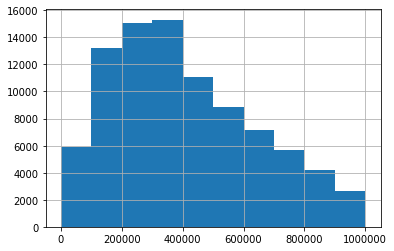

In [35]:
df_clean.loc[df_clean.PRICE < 1_000_000,:].PRICE.hist()

In [36]:
# Filter based on QUALIFIED
df_clean_index = df_clean.index
df_qualified_index = df.loc[df.QUALIFIED == 'Q'].index
df_clean = df_clean.loc[(df_qualified_index.intersection(df_clean_index))]

In [37]:
df_clean.shape

(76233, 12)

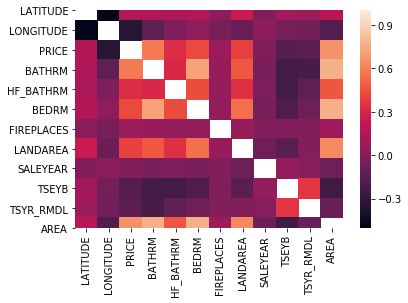

In [38]:
mask = np.diag(np.ones(12))==1
sns.heatmap(df_clean.corr(),mask=mask)

In [39]:
# from sklearn.ensemble import IsolationForest
# IF = IsolationForest()
# outliers = IF.fit_predict(df_clean)

# df_clean = df_clean.loc[outliers == 1]

In [54]:
np.unique(outliers,return_counts=True)

NameError: name 'outliers' is not defined

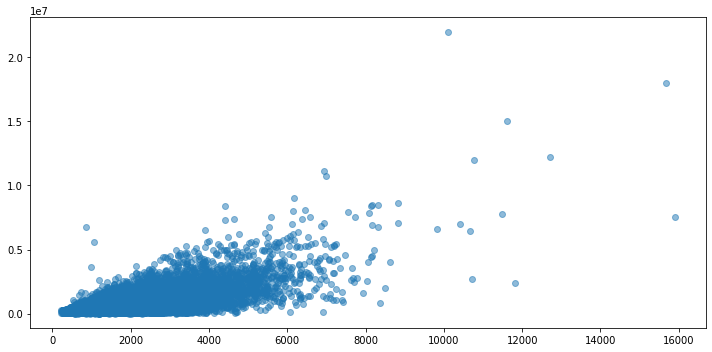

In [55]:
# plt.scatter(tmp_data_res['GBA'],tmp_data_res['PRICE'])
f,ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(df_clean.loc[:,'AREA'],
           df_clean.loc[:,'PRICE'],alpha=0.5)

plt.tight_layout()
plt.show()

In [56]:
# Remove outliers


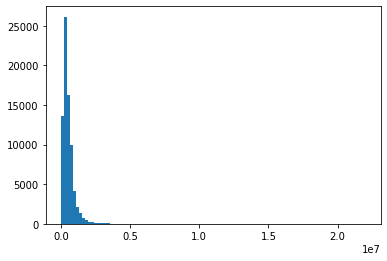

In [57]:
plt.hist(df_clean.PRICE,bins=100)
plt.show()

# Modeling with data

In [58]:
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV,train_test_split,cross_val_score,KFold
from sklearn.metrics import r2_score

In [59]:
X = df_clean.drop('PRICE',axis=1)
y = df_clean.loc[:,'PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)

In [60]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_train)
print('test score:',r2_score(y_test,y_pred_test))
print('train score:',r2_score(y_train,y_pred_train))

test score: 0.5121969453044086
train score: 0.5371952756023186


In [61]:
reg = Lasso(alpha=300)
reg.fit(X_train,y_train)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_train)
print('test score:',r2_score(y_test,y_pred_test))
print('train score:',r2_score(y_train,y_pred_train))

test score: 0.5093299388947451
train score: 0.535755886407546


In [62]:
reg = RandomForestRegressor(n_estimators=5)
reg.fit(X_train,y_train)
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_train)
print('test score:',r2_score(y_test,y_pred_test))
print('train score:',r2_score(y_train,y_pred_train))

test score: 0.7818575715261953
train score: 0.9600837099567997


In [63]:
X_train,y_train

(         LATITUDE  LONGITUDE  BATHRM  HF_BATHRM  BEDRM  FIREPLACES  LANDAREA  \
 134051  38.920133 -77.027795     2.0        0.0    2.0         0.0     467.0   
 61321   38.944079 -77.016574     2.0        0.0    3.0         0.0    2800.0   
 49725   38.923719 -77.026028     2.0        1.0    3.0         0.0    1000.0   
 49754   38.951687 -77.028166     3.0        1.0    3.0         1.0    4946.0   
 89368   38.881401 -76.930495     2.0        1.0    3.0         0.0    2787.0   
 ...           ...        ...     ...        ...    ...         ...       ...   
 83206   38.897135 -76.973620     3.0        1.0    3.0         0.0    1556.0   
 12789   38.890800 -76.991295     1.0        1.0    2.0         1.0    1000.0   
 122763  38.910524 -77.039982     1.0        0.0    1.0         0.0     137.0   
 1756    38.881472 -77.020849     3.0        1.0    3.0         0.0    1271.0   
 31898   38.955308 -77.076298     4.0        1.0    5.0         2.0    5196.0   
 
         SALEYEAR  TSEYB  

In [64]:
# est = RandomForestRegressor()
# params = {'n_estimators':np.logspace(1,np.log(500),7,base=np.e).astype(int),
#           'max_depth':list(np.logspace(np.log(3),np.log(15),5,base=np.e).astype(int))+ [None]}

# reg = GridSearchCV(est, param_grid=params, cv=5, n_jobs=-1,scoring='r2',return_train_score =True,verbose=5)
# reg.fit(X_train,y_train)

In [65]:
# test_score = reg.cv_results_['mean_test_score']
# train_score = reg.cv_results_['mean_train_score']

In [66]:
# import seaborn as sns
# sns.heatmap(test_score.reshape(7,6));plt.show()
# sns.heatmap(train_score.reshape(7,6));plt.show()

In [67]:
# print(reg.best_score_)
# print(reg.best_params_)

In [68]:
final_model = Lasso(alpha=300)#Lasso()#RandomForestRegressor(n_estimators= 10,max_depth= None,n_jobs=-1)
final_model.fit(X.drop('FIREPLACES',axis=1),y)

Lasso(alpha=300, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [69]:
y_pred = final_model.predict(X.drop('FIREPLACES',axis=1))

In [70]:
residuals_df = X.copy()
residuals_df.loc[:,'Residuals'] = y_pred - y

In [71]:
def scatter_heat_map(df,variable,title):
    var_by_loc =df.groupby(['LATITUDE','LONGITUDE']).mean().loc[:,variable]
    var_by_loc_99 = var_by_loc[var_by_loc<np.quantile(var_by_loc.dropna(),0.99)]
    plt.figure(figsize=(10,10))
    plt.scatter(var_by_loc_99.index.get_level_values('LATITUDE'),
                var_by_loc_99.index.get_level_values('LONGITUDE'),
                c=var_by_loc_99,
               s=2,cmap='plasma')
    plt.title(title,fontsize=25)
    plt.xticks([])
    plt.yticks([])
    plt.show()

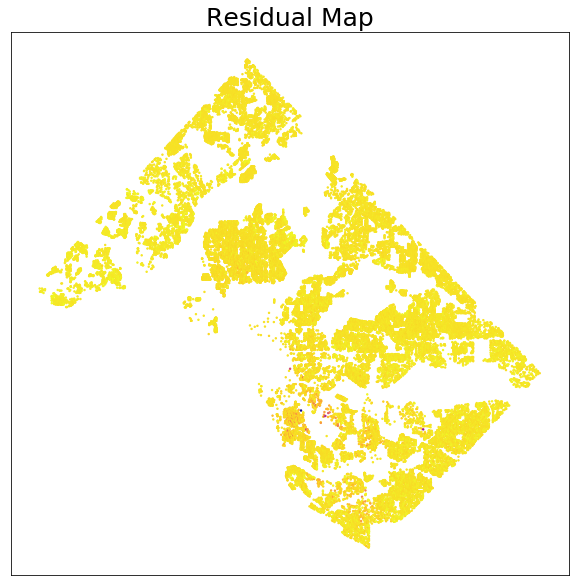

In [72]:
scatter_heat_map(residuals_df,'Residuals','Residual Map')


In [73]:
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [74]:
df.AYB.min()

1754.0

In [75]:
df[df.AYB < 1800]

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
2678,2678,2.0,1.0,Forced Air,Y,1.0,6.0,3.0,1780.0,1979.0,1967.0,2.00,NaT,NaN,U,1.0,2372.0,1,2 Story,Single,Above Average,Good,Common Brick,Built Up,Hardwood,1.0,1.0,12,2134.0,2018-07-22 18:01:43,Residential,NaN,NaN,822 25TH STREET NW,WASHINGTON,DC,20037.0,18S UJ 21921 07711,38.900239,-77.053563,Foggy Bottom,NaN,5600.0,005600 2000,Ward 2,17,-77.053872,38.900448,NW
5128,5128,3.0,0.0,Hot Water Rad,N,2.0,5.0,3.0,1776.0,1984.0,1957.0,2.00,1998-07-22,223500.0,Q,1.0,1224.0,1,2 Story,Row Inside,Above Average,Good,Common Brick,Built Up,Hardwood,2.0,3.0,24,1611.0,2018-07-22 18:01:43,Residential,NaN,NaN,41 D STREET SE,WASHINGTON,DC,20003.0,18S UJ 25963 05918,38.884904,-77.006521,Capitol Hill,009 A Capitol Hill,6500.0,006500 2007,Ward 6,694,-77.006351,38.884360,SE
5130,5130,2.0,1.0,Hot Water Rad,N,1.0,6.0,4.0,1776.0,1998.0,1967.0,2.00,2009-04-17,725000.0,Q,1.0,1292.0,1,2 Story,Row Inside,Above Average,Good,Common Brick,Built Up,Hardwood,1.0,1.0,11,1605.0,2018-07-22 18:01:43,Residential,NaN,NaN,47 D STREET SE,WASHINGTON,DC,20003.0,18S UJ 25979 05916,38.884894,-77.006333,Capitol Hill,009 A Capitol Hill,6500.0,006500 2007,Ward 6,694,-77.006351,38.884360,SE
5563,5563,2.0,1.0,Hot Water Rad,N,1.0,6.0,3.0,1776.0,1959.0,1957.0,2.00,2016-05-24,NaN,U,3.0,1224.0,1,2 Story,Row Inside,Above Average,Average,Common Brick,Built Up,Hardwood,1.0,3.0,11,1536.0,2018-07-22 18:01:43,Residential,NaN,NaN,43 D STREET SE,WASHINGTON,DC,20003.0,18S UJ 25968 05918,38.884908,-77.006464,Capitol Hill,009 A Capitol Hill,6500.0,006500 2007,Ward 6,694,-77.006351,38.884360,SE
8600,8600,1.0,1.0,Hot Water Rad,N,1.0,6.0,3.0,1782.0,2015.0,1960.0,2.00,NaT,NaN,U,1.0,2368.0,1,2 Story,Row End,Good Quality,Good,Common Brick,Metal- Sms,Wood Floor,1.0,4.0,11,2152.0,2018-07-22 18:01:43,Residential,NaN,NaN,423 6TH STREET SE,WASHINGTON,DC,20003.0,18S UJ 26641 05746,38.883489,-76.998668,Capitol Hill,009 A Capitol Hill,6500.0,006500 2001,Ward 6,845,-76.998982,38.883850,SE
18326,18326,2.0,0.0,Hot Water Rad,N,1.0,7.0,3.0,1790.0,1986.0,1976.0,3.00,1996-01-19,812500.0,Q,1.0,4040.0,1,3 Story,Row Inside,Superior,Good,Common Brick,Metal- Sms,Hardwood,1.0,1.0,11,2400.0,2018-07-22 18:01:43,Residential,NaN,NaN,3031 O STREET NW,WASHINGTON,DC,20007.0,18S UJ 21349 08659,38.908666,-77.060396,Georgetown,025 G Georgetown,100.0,000100 3006,Ward 2,1257,-77.060318,38.908907,NW
18727,18727,6.0,1.0,Warm Cool,Y,1.0,14.0,8.0,1787.0,2011.0,1976.0,3.00,NaT,NaN,U,1.0,7794.0,1,3 Story,Single,Superior,Good,Common Brick,Slate,Hardwood,1.0,1.0,12,18740.0,2018-07-22 18:01:43,Residential,NaN,NaN,3508 PROSPECT STREET NW,WASHINGTON,DC,20007.0,18S UJ 20556 08352,38.905738,-77.069463,Georgetown,025 B Georgetown,202.0,000202 4006,Ward 2,1203,-77.069272,38.905321,NW
18861,18861,4.0,2.0,Hot Water Rad,Y,1.0,14.0,6.0,1795.0,1987.0,1983.0,3.00,NaT,NaN,U,1.0,6895.0,1,3 Story,Single,Exceptional-A,Good,Common Brick,Metal- Cpr,Hardwood,1.0,3.0,12,9600.0,2018-07-22 18:01:43,Residential,NaN,NaN,3040 DUMBARTON STREET NW,WASHINGTON,DC,20007.0,18S UJ 21307 08525,38.907447,-77.060854,Georgetown,025 G Georgetown,100.0,000100 4002,Ward 2,1233,-77.060123,38.907180,NW
19181,19181,2.0,1.0,Hot Water Rad,Y,1.0,8.0,4.0,1791.0,1991.0,1990.0,2.50,2013-02-25,NaN,U,1.0,2162.0,1,2.5 Story Fin,Semi-Detached,Superior,Good,Stucco,Metal- Sms,Hardwood,1.0,5.0,13,1950.0,2018-07-22 18:01:43,Residential,NaN,NaN,1404 35TH STREET NW,WASHINGTON,DC,20007.0,18S UJ 20578 08597,38.907946,-77.069267,Georgetown,025 B Georgetown,202.0,000202 4000,Ward 2,1247,-77.069779,38.908190,NW
19304,19304,5.0,1.0,Warm Cool,Y,1.0,11.0,6.0,1794.0,1970.0,1986.0,3.00,2017-05-24,5250000.

(2000, 2020)

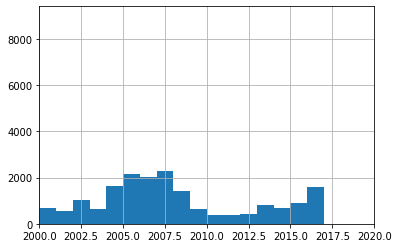

In [76]:
df.AYB.hist(bins=np.arange(1750,2018))
plt.xlim(2000,2020)

In [77]:
df.HEAT.value_counts()

Forced Air        53972
Hot Water Rad     47202
Warm Cool         33628
Ht Pump           21412
Wall Furnace       1120
Water Base Brd      402
Elec Base Brd       351
No Data             330
Electric Rad        144
Gravity Furnac      140
Air-Oil             117
Ind Unit             50
Evp Cool             50
Air Exchng           39
Name: HEAT, dtype: int64

In [78]:
df_clean.loc[:,'AREA_M2'] = df_clean.loc[:,'AREA']/10.7639

In [79]:
df_clean.to_csv('../Data/Properties_clean.csv')

In [80]:
df_clean.dtypes

LATITUDE      float64
LONGITUDE     float64
PRICE         float64
BATHRM        float64
HF_BATHRM     float64
BEDRM         float64
FIREPLACES    float64
LANDAREA      float64
SALEYEAR      float64
TSEYB         float64
TSYR_RMDL     float64
AREA          float64
AREA_M2       float64
dtype: object